In [18]:
import pandas as pd
import os
import sys

module_path = os.path.abspath(os.path.join("..", "src"))
if module_path not in sys.path:
    sys.path.append(module_path)
    
tickers = pd.read_csv("../data/raw/tessa_sp500_prices.csv").columns.tolist()[2:]

In [2]:
# Commission fee based on Webull, which is known for low commission fees:
# https://www.webull.com.sg/pricing
# Regular and Extended Hours (04:00 - 20:00 EST)
# 0.025%*Total Trade Amount (Min. USD 0.50)

def commission(order_size, price):
    return max(0.5, abs(order_size) * price * 0.00025)

In [104]:
import yfinance as yf
import tqdm
import pickle as pkl

start_date = "2025-02-01"
end_date = "2025-04-01" # Last day is exclusive

portfolio = {}
for asset in tqdm.tqdm(['SPY', 'INTC', 'CZR', 'GME']):
    portfolio[asset] = {
        "data": yf.Ticker(asset).history(start=start_date, end=end_date, actions=False),
    }
    
portfolio


100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


{'SPY': {'data':                                  Open        High         Low       Close  \
  Date                                                                        
  2025-02-03 00:00:00-05:00  590.892432  598.489573  588.718978  595.977173   
  2025-02-04 00:00:00-05:00  596.036993  600.493558  595.488655  599.975159   
  2025-02-05 00:00:00-05:00  598.838557  602.557350  596.784738  602.407776   
  2025-02-06 00:00:00-05:00  604.172499  604.631141  600.822591  604.501526   
  2025-02-07 00:00:00-05:00  605.069841  606.306112  598.250328  598.968201   
  2025-02-10 00:00:00-05:00  602.218402  603.683964  600.932232  603.035889   
  2025-02-11 00:00:00-05:00  600.742836  604.042906  600.623201  603.494568   
  2025-02-12 00:00:00-05:00  597.402918  602.736848  596.714985  601.550415   
  2025-02-13 00:00:00-05:00  602.667052  608.110698  601.390922  607.901306   
  2025-02-14 00:00:00-05:00  608.110669  609.157508  607.243284  607.871399   
  2025-02-18 00:00:00-05:00  609.0478

In [116]:
from backtesting import Strategy
import xgboost as xgb
import ta
import pandas as pd

'''
Note: This model needs 1 month of data to predict the next day's change.
'''

class XGBFactory:
    @staticmethod
    def get(path_to_model, buy_threshold, close_threshold):
        class XGBCustom(XGB):
            def init(self):
                super().init(
                    path_to_model=path_to_model,
                    buy_threshold=buy_threshold,
                    close_threshold=close_threshold
                )
        return XGBCustom
    

def add_features(prices):
    indicators = ta.add_all_ta_features(prices, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    indicators['ema2'] = indicators['Close'].ewm(span=2, adjust=False).mean()
    indicators['ema3'] = indicators['Close'].ewm(span=3, adjust=False).mean()
    indicators['ema4'] = indicators['Close'].ewm(span=4, adjust=False).mean()
    indicators['ema5'] = indicators['Close'].ewm(span=5, adjust=False).mean()
    indicators['ema6'] = indicators['Close'].ewm(span=6, adjust=False).mean()
    indicators['ema7'] = indicators['Close'].ewm(span=7, adjust=False).mean()
    indicators['ema10'] = indicators['Close'].ewm(span=10, adjust=False).mean()
    indicators['ema20'] = indicators['Close'].ewm(span=20, adjust=False).mean()
    indicators['ema50'] = indicators['Close'].ewm(span=50, adjust=False).mean()
    indicators['ema100'] = indicators['Close'].ewm(span=100, adjust=False).mean()
    return indicators.copy()


class XGB(Strategy):
    def init(self, path_to_model, buy_threshold, close_threshold):
        self.model = xgb.Booster()
        self.model.load_model(path_to_model)
        self.buy_threshold = buy_threshold
        self.close_threshold = close_threshold
        
    def next(self):
        if len(self.data) < 28:
            return
        
        df = pd.DataFrame({
            "Open": self.data.Open.s,
            "High": self.data.High.s,
            "Low": self.data.Low.s,
            "Close": self.data.Close.s,
            "Volume": self.data.Volume.s
        })
        
        indicators = add_features(df).iloc[-1:]
        y_pred = self.model.predict(xgb.DMatrix(indicators))[0]
        
        if y_pred > self.buy_threshold:
            self.buy()
        elif y_pred < self.close_threshold:
            self.position.close()

In [117]:
from backtesting import Backtest
asset = 'SPY'

data = portfolio[asset]["data"]
data.index = data.index.values.astype("datetime64[D]")
bt = Backtest(
    data, XGBFactory.get(f"../data/processed/xgb/{asset}.json"), cash=1000000, commission=commission, finalize_trades=True
)
run_stats = bt.run().to_dict()
stats = {'asset': asset, '_strategy': 'Unknown'}
stats.update(run_stats)

bt.plot()

GridPlot(id='p6262', ...)

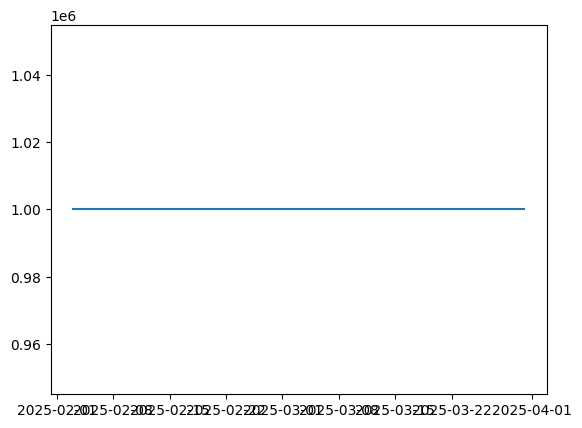

In [107]:
#plot stats['_equity_curve']

import matplotlib.pyplot as plt
plt.plot(stats['_equity_curve']['Equity'])
plt.show()


In [108]:
stats['_equity_curve'][stats['_equity_curve']['Equity'] > 1.000000e+06]


,Equity,DrawdownPct,DrawdownDuration


In [109]:
stats['_trades']


,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,SL,TP,PnL,ReturnPct,EntryTime,ExitTime,Duration,Tag
